In [9]:
import statistics
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scripts import strip_detection

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [10]:
test_files = ['dilution1',
              'dilution2',
              'dilution3',
              'dilution4',
              'dilution5']

# test_files = ['SL-IV-1',
#               'EBOV-1-G2']

# #               'EBOV-2-G9', # too dark
# #              'SL-LOD-1.jpg', # too dark
              
#               'LF-1-patients',
#               'N2-LOD-1',
#               'N2-LOD-2',
#               'N2-LOD-3',
#               'NG-LOD-1']

LODStandardDeviation = 31

In [13]:
def getTruthValueFromFile(filename):
    if filename is None:
        return []
    truth_values = []
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line != 'pos' and line != 'neg':
                raise Exception('Truth file contains line other than "pos" or "neg"')
            if line == 'pos':                    
                truth_values.append(1)
            else:
                truth_values.append(0)
    return truth_values

def score_confidence_interval(score_fun, y_true, y_pred, pvalue, niter):
    """
    Calculation of the confidence interval for a given p-value using bootstrap sampling
    http://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
    """
    
    n_bootstraps = niter
    bootstrapped_scores = []
    
#     rng_seed = 42  # control reproducibility
#     rng = np.random.RandomState(rng_seed)

    rng = np.random.RandomState()
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))
        
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = score_fun(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int((1 - pvalue) * len(sorted_scores))] 
    confidence_upper = sorted_scores[int(pvalue * len(sorted_scores))]

    return [confidence_lower, confidence_upper]

def auc_confidence_interval(y_true, y_pred, pvalue=0.95, niter=1000):
    return score_confidence_interval(roc_auc_score, y_true, y_pred, pvalue, niter)


def getStripPixelAreaFromFile(filename):
    if filename is None:
        return None
    with open(filename) as file:
        for line in file:
            return int(line)

In [14]:
all_scores = []
all_truths = []
for test in test_files:
    img_fn = 'images/' + test + ".jpg"
    tru_fn = 'images/' + test + ".txt"

    t = getTruthValueFromFile(tru_fn)
    s = strip_detection.getPredictions(img_fn, getStripPixelAreaFromFile('images/' + test + '_size.txt') )
    all_scores += s
    all_truths += t[:-1]
    print(img_fn)
    print(t)
    print(s)

images/dilution1.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 1, 0.539957820652482]
images/dilution2.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 1, 0.4793770444591142]
images/dilution3.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 0.6625761563396886, 0.545974891251199, 0.5877678712983906, 0.7379486915730985]
images/dilution4.jpg
[1, 1, 1, 1, 0, 0]
[1, 1, 1, 0.4180323783754937, 0.4829995205943035]
images/dilution5.jpg
[1, 1, 1, 0, 0]
[1, 1, 1, 0.8171265868346589]


In [22]:
class_threshold = 0.8
p_value = 0.95
all_preds = np.array([int(class_threshold < p) for p in all_scores])

ytrue = np.array(all_truths)
probs = np.array(all_scores)
ypred = all_preds

auc = roc_auc_score(ytrue, probs)
fpr, tpr, thresholds = roc_curve(ytrue, probs) 
brier = brier_score_loss(ytrue, probs)
# cal, dis = caldis(ytrue, probs)
acc = accuracy_score(ytrue, ypred)
precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

auc_ci = auc_confidence_interval(ytrue, probs, p_value)

P = N = 0
TP = TN = 0
FP = FN = 0
for i in range(len(ytrue)):
    if ytrue[i] == 1:
        P += 1
        if ypred[i] == 1: TP += 1
        else: FN += 1
    else:
        N += 1
        if ypred[i] == 0: TN += 1
        else: FP += 1
            
sens = float(TP)/P
spec = float(TN)/N

# Positive and Negative Predictive Values
# https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values
ppv = float(TP) / (TP + FP)
npv = float(TN) / (TN + FN)
        
# Likelihood ratios
# https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing
lr_pos = sens / (1 - spec) if spec < 1 else np.inf
lr_neg = (1 - sens) / spec if 0 < spec else np.inf

# print "True outcomes:", ytrue
# print "Prediction   :", ypred
cfr = 100 * (float(np.sum(ytrue)) / len(ytrue))
print("Number of strips   :", len(ytrue))
print("Number of positives:", np.sum(ytrue)) 
print("Perc. of positives : %0.2f" % cfr)

print("")
print("Measures of performance") 
print("AUC           : %0.2f (%0.2f, %0.2f)" % (auc, auc_ci[0], auc_ci[1])) 
print("Brier         : %0.2f" % brier) 
# print("Calibration   :", cal) 
# print("Discrimination:", dis) 
print("Accuracy      : %0.2f" % acc) 
print("Sensitivity   : %0.2f" % sens) 
print("Specificity   : %0.2f" % spec) 
# print("PPV           : %0.2f" % ppv) 
# print("NPV           : %0.2f" % npv) 

Number of strips   : 27
Number of positives: 22
Perc. of positives : 81.48

Measures of performance
AUC           : 0.90 (0.82, 1.00)
Brier         : 0.10
Accuracy      : 0.81
Sensitivity   : 0.82
Specificity   : 0.80


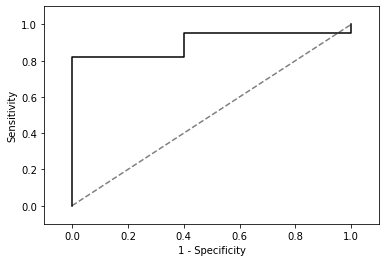

In [23]:
fig, ax = plt.subplots()
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.plot(fpr, tpr, color='black')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
fig.savefig('reader-roc.pdf')